In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dictys.net import dynamic_network
from utils_custom import *

## Execute the analysis

In [5]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
# Define the transcription factors
tf_list = ['IRF4', 'IRF8', 'PRDM1', 'BCL6', 'BATF', 'SPIB']

In [28]:
tf_list_GC = ['PAX5', 'IKZF1', 'NFKB1', 'IRF1', 'NFIL3', 'MEF2C']
tf_list_PB = ['SPI1','JUNB','SP3','TCF12','STAT1']

In [6]:
# Load data
dictys_dynamic_object = load_data(data_file)

In [7]:
# Get the TF indices
tf_indices, gene_indices = get_tf_indices(dictys_dynamic_object, tf_list)
print(f"TF indices: {tf_indices}")
print(f"Gene indices: {gene_indices}")

TF indices: [97, 100, 172, 12, 10, 204]
Gene indices: [5093, 5096, 8469, 1044, 997, 10503]


In [29]:
tf_indices_GC, gene_indices_GC = get_tf_indices(dictys_dynamic_object, tf_list_GC)
tf_indices_PB, gene_indices_PB = get_tf_indices(dictys_dynamic_object, tf_list_PB)
print(f"TF indices: {tf_indices_GC}")
print(f"Gene indices: {gene_indices_GC}")
print(f"TF indices: {tf_indices_PB}")
print(f"Gene indices: {gene_indices_PB}")

TF indices: [163, 93, 143, 94, 142, 127]
Gene indices: [7746, 4929, 7193, 5087, 7191, 6374]
TF indices: [203, 104, 201, 206]
Gene indices: [10502, 5200, 10443, 10669]


In [8]:
# Assign window indices for each branch between 0 to 60
pb_window_indices = list(range(30, 46)) + [2]
abc_window_indices = [1] + list(range(4, 30)) + [0]
gc_window_indices = list(range(46, 61)) + [3]

### Regulation strength across each branch

In [12]:
# Debug information before getting weights
print("==== Debug Information ====")
print("Array shape:", dictys_dynamic_object.prop['es']['w_n'].shape)
print("TF indices:", tf_indices)
print("PB window indices:", pb_window_indices)
print("ABC window indices:", abc_window_indices)
print("GC window indices:", gc_window_indices)
print("========================")

# get normalized weights
weights_of_tf_target_pb = get_weights_across_windows(dictys_dynamic_object, tf_indices, pb_window_indices)
weights_of_tf_target_abc = get_weights_across_windows(dictys_dynamic_object, tf_indices, abc_window_indices)
weights_of_tf_target_gc = get_weights_across_windows(dictys_dynamic_object, tf_indices, gc_window_indices)

==== Debug Information ====
Array shape: (245, 13169, 61)
TF indices: [97, 100, 172, 12, 10, 204]
PB window indices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 2]
ABC window indices: [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 0]
GC window indices: [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 3]


In [13]:
# get normalized weights
weights_of_tf_target_pb = get_weights_across_windows(dictys_dynamic_object, tf_indices, pb_window_indices)
weights_of_tf_target_abc = get_weights_across_windows(dictys_dynamic_object, tf_indices, abc_window_indices)
weights_of_tf_target_gc = get_weights_across_windows(dictys_dynamic_object, tf_indices, gc_window_indices)
print(weights_of_tf_target_pb.shape)
print(weights_of_tf_target_abc.shape)
print(weights_of_tf_target_gc.shape)


(6, 13169, 17)
(6, 13169, 28)
(6, 13169, 16)


In [14]:
# get non-zero weights per tf (node-degree)
non_zero_weights_per_tf_pb = np.count_nonzero(weights_of_tf_target_pb, axis=1)
non_zero_weights_per_tf_abc = np.count_nonzero(weights_of_tf_target_abc, axis=1)
non_zero_weights_per_tf_gc = np.count_nonzero(weights_of_tf_target_gc, axis=1)


In [16]:
# subset the weight matrix to only include the gene_indices from our TF list
weights_of_tf_target_pb_subset = weights_of_tf_target_pb[:, gene_indices, :]
weights_of_tf_target_abc_subset = weights_of_tf_target_abc[:, gene_indices, :]
weights_of_tf_target_gc_subset = weights_of_tf_target_gc[:, gene_indices, :]

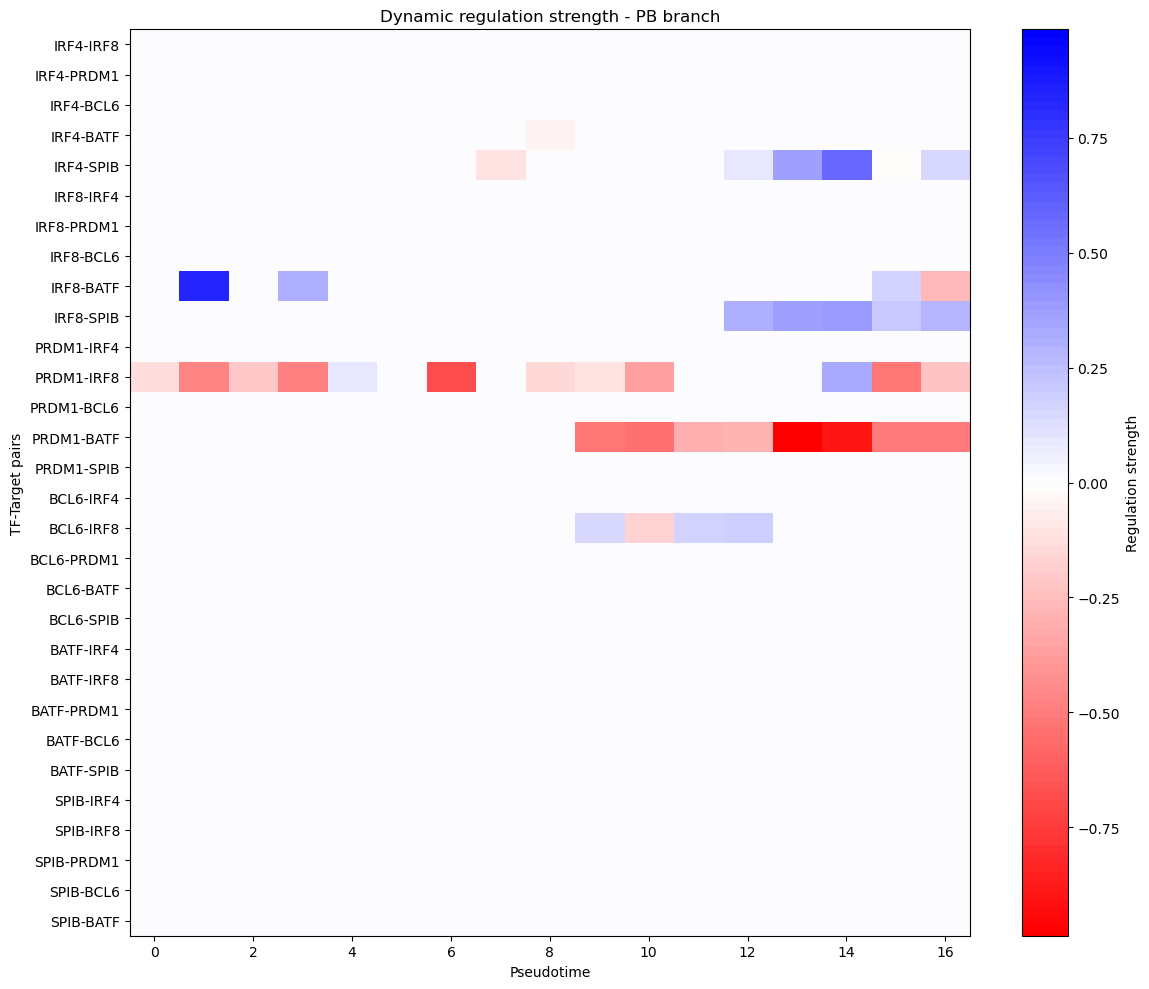

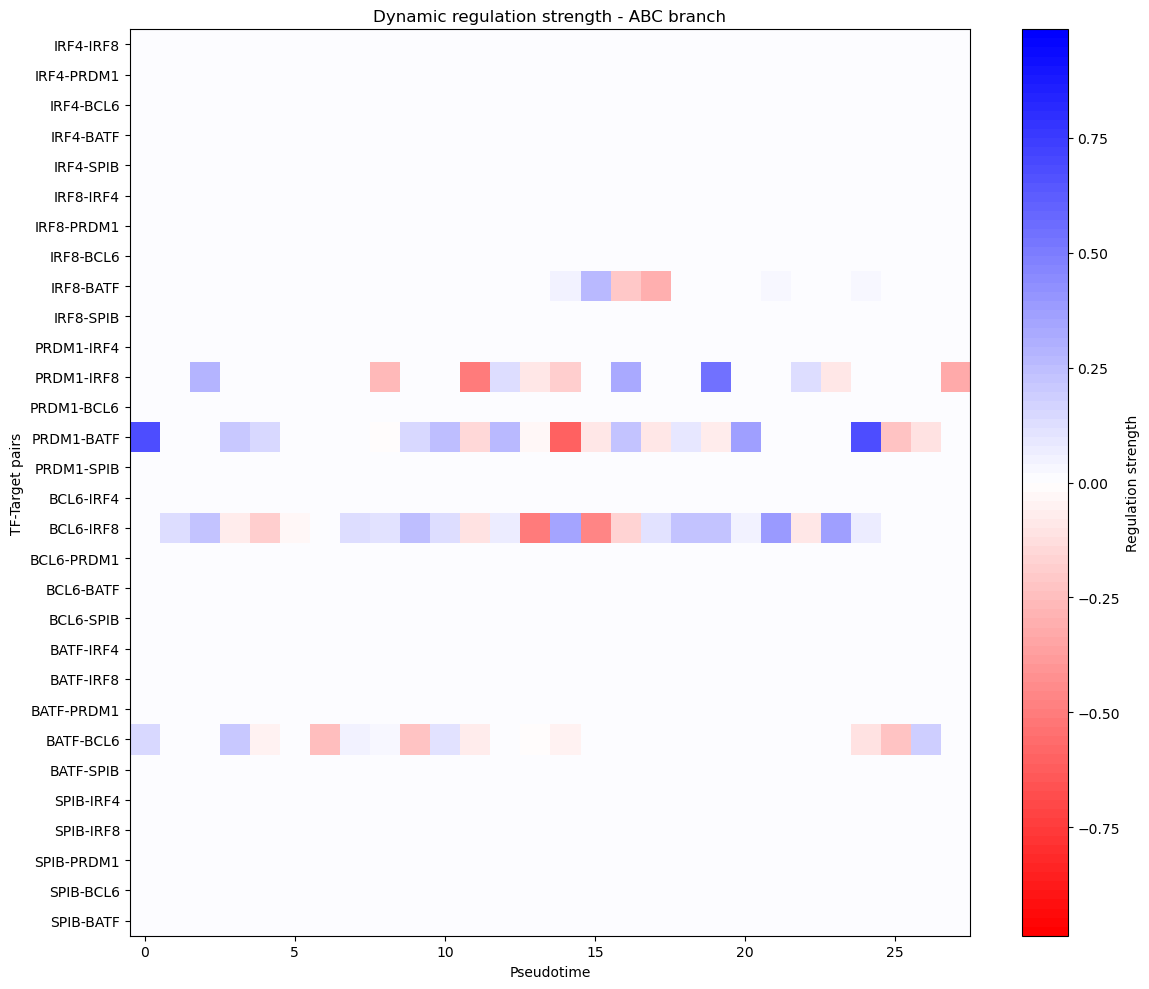

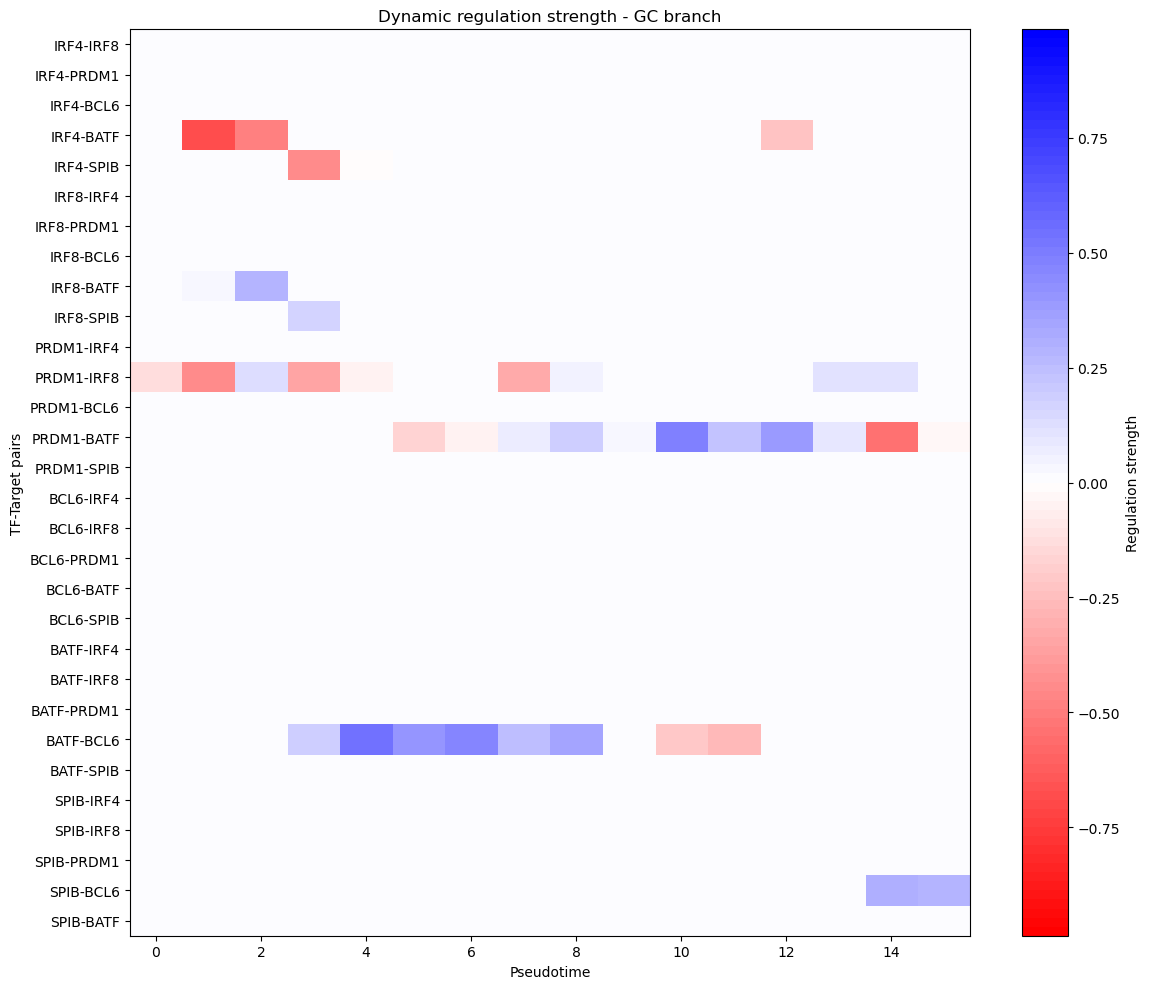

In [17]:
# Calculate global min and max across all branches
all_weights = np.concatenate([
    weights_of_tf_target_pb_subset.flatten(),
    weights_of_tf_target_abc_subset.flatten(),
    weights_of_tf_target_gc_subset.flatten()
])
global_vmin = np.min(all_weights)
global_vmax = np.max(all_weights)
global_vmax = max(abs(global_vmin), abs(global_vmax))
global_vmin = -global_vmax

# plot heatmap of weights per branch
plot_regulation_heatmap(weights_of_tf_target_pb_subset, tf_list, 'PB', global_vmin, global_vmax)
plot_regulation_heatmap(weights_of_tf_target_abc_subset, tf_list, 'ABC', global_vmin, global_vmax)
plot_regulation_heatmap(weights_of_tf_target_gc_subset, tf_list, 'GC', global_vmin, global_vmax)


### Expression of TFs across branches

IndexError: index 4 is out of bounds for axis 0 with size 4

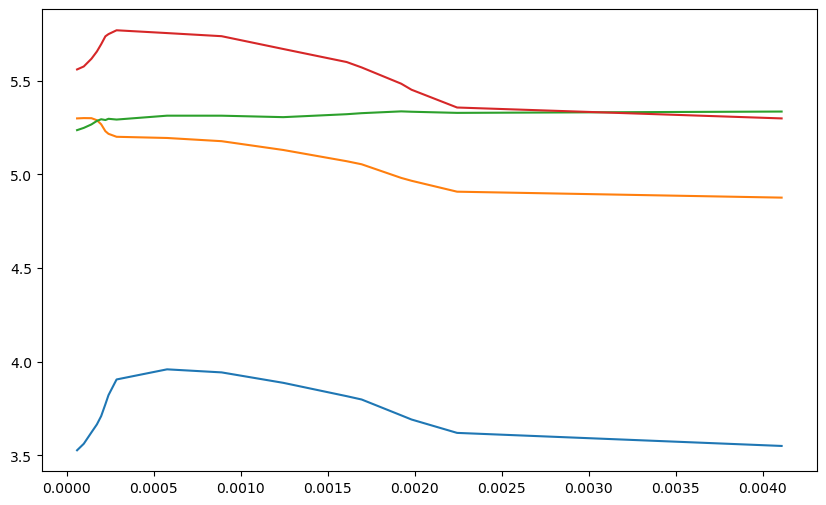

In [30]:
# plot log CPM of TFs across branches
plot_log_cpm_tfs(dictys_dynamic_object, gene_indices_PB, pb_window_indices, tf_list_PB, 'PB')
plot_log_cpm_tfs(dictys_dynamic_object, gene_indices_PB, gc_window_indices, tf_list_PB, 'GC')
